Running version 0.3.0...
Previous condition number: 1726.0649075446854
New condition number: 1726.0649075446854


C:\Users\sudom\AppData\Local\Temp\ipykernel_12464\1713113132.py:154: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Итерация 5: Ошибка = 22.56, α = 0.2927, γ = 0.1951
Итерация 10: Ошибка = 9.22, α = 0.2857, γ = 0.1905
Итерация 15: Ошибка = 3.84, α = 0.2791, γ = 0.1860
Итерация 20: Ошибка = 1.78, α = 0.2727, γ = 0.1818
Итерация 25: Ошибка = 0.77, α = 0.2667, γ = 0.1778
Итерация 30: Ошибка = 0.38, α = 0.2609, γ = 0.1739
Итерация 35: Ошибка = 0.19, α = 0.2553, γ = 0.1702
Итерация 40: Ошибка = 0.09, α = 0.2500, γ = 0.1667
Итерация 45: Ошибка = 0.04, α = 0.2449, γ = 0.1633
Итерация 50: Ошибка = 0.02, α = 0.2400, γ = 0.1600
Итерация 55: Ошибка = 0.01, α = 0.2353, γ = 0.1569
Итерация 60: Ошибка = 0.01, α = 0.2308, γ = 0.1538
Итерация 65: Ошибка = 0.00, α = 0.2264, γ = 0.1509
Итерация 70: Ошибка = 0.00, α = 0.2222, γ = 0.1481
Итерация 75: Ошибка = 0.00, α = 0.2182, γ = 0.1455

Running version 0.4.0...
Previous condition number: 1726.0649075446854
New condition number: 1726.0649075446854
Итерация 5: Ошибка = 22.76, α = 0.2857, γ = 0.1905
Итерация 10: Ошибка = 8.36, α = 0.2727, γ = 0.1818
Итерация 15: Ошибка 

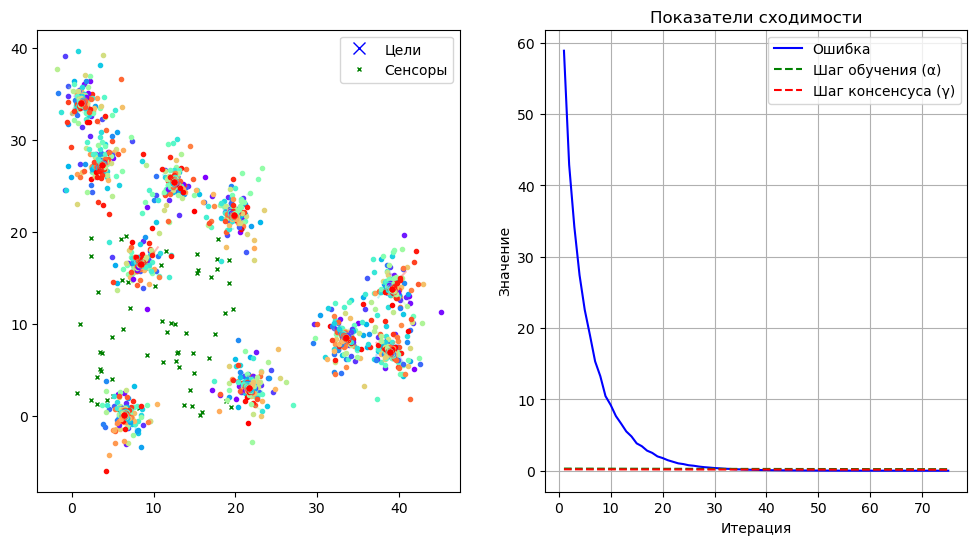

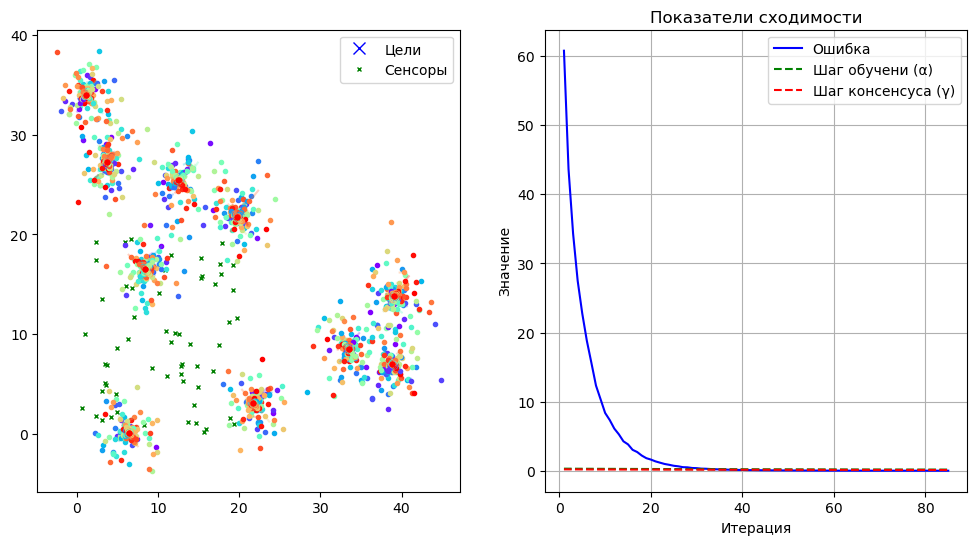

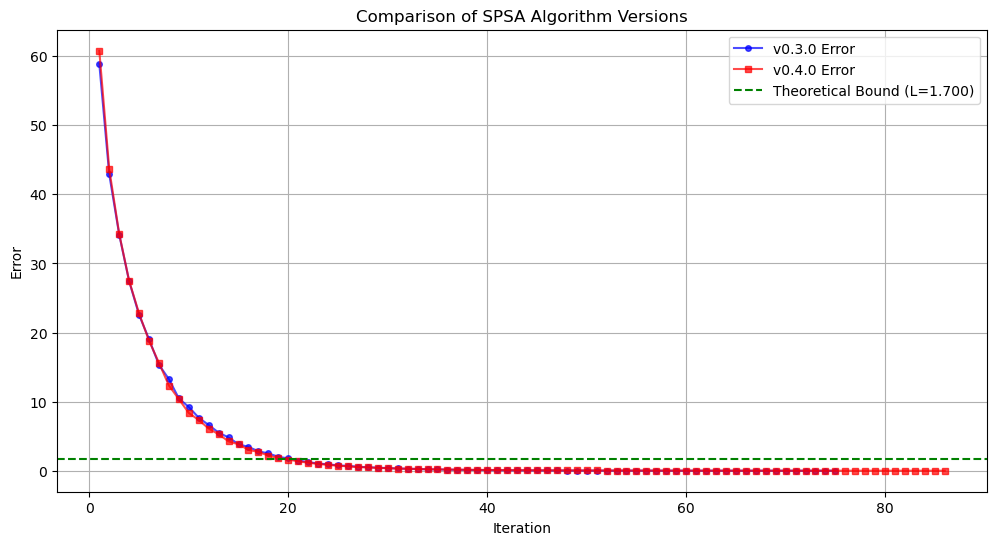

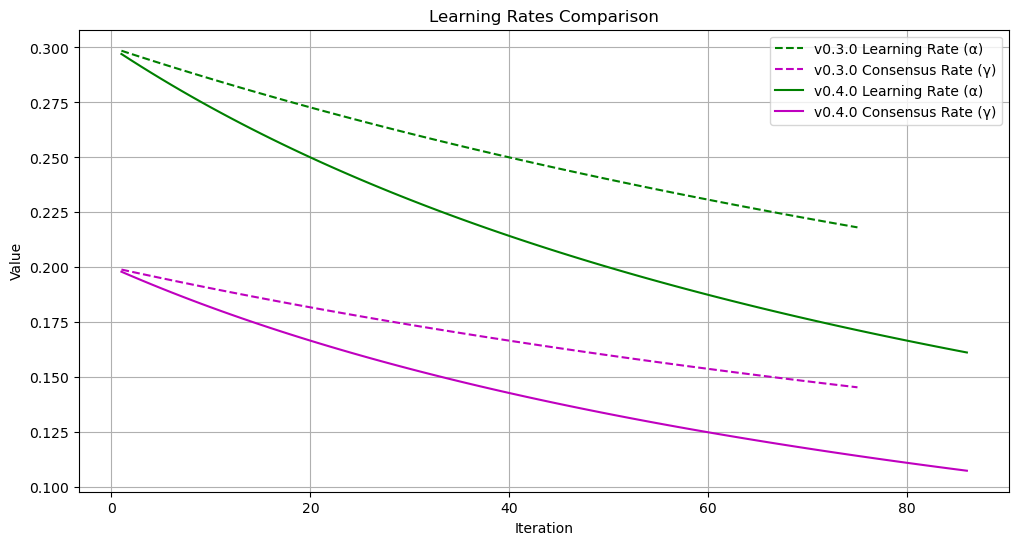

In [1]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
import time
import numpy as np
from random import random, randrange, sample
import plotly.graph_objects as go
import plotly
from typing import Dict, List, Set, Optional

class Parameters:
    def __init__(self):
        self.d = 2  # number of dimensions (2D space)
        self.n = 0  # will be set when sensors are added
        self.m = 0  # will be set when targets are added
        self.N: Set[int] = set()  # indexes of sensors
        self.M: Set[int] = set()  # targets indexes
        self.s: Dict[int, np.ndarray] = {}  # sensors coordinates
        self.s_norms: Dict[int, float] = {}  # norms of sensors coordinates
        self.r: Dict[int, np.ndarray] = {}  # targets coordinates
        self.meas: Dict[int, Dict[int, float]] = {}  # measurements
        self.weight: np.ndarray = np.array([])  # weight matrix
        
        # Algorithm parameters (tunable)
        self.beta_1 = 0.05   # perturbation parameter
        self.beta_2 = 0.05   # perturbation parameter
        self.alpha_base = 0.3  # base learning rate (will adapt)
        self.gamma_base = 0.2  # base consensus parameter (will adapt)
        self.momentum = 0.95   # Nesterov momentum parameter
        self.b = 1.0          # noise bound
        
    @property
    def beta(self):
        return self.beta_1 + self.beta_2
    
    def add_sensor(self, sensor_id: int, coordinates: np.ndarray):
        """Add a sensor with given ID and coordinates"""
        if sensor_id in self.N:
            raise ValueError(f"Sensor with ID {sensor_id} already exists")
        
        self.N.add(sensor_id)
        self.s[sensor_id] = coordinates
        self.s_norms[sensor_id] = np.sum(coordinates * coordinates)
        self.n = len(self.N)
        
    def add_target(self, target_id: int, coordinates: np.ndarray):
        """Add a target with given ID and coordinates"""
        if target_id in self.M:
            raise ValueError(f"Target with ID {target_id} already exists")
        
        self.M.add(target_id)
        self.r[target_id] = coordinates
        self.m = len(self.M)
        
    def generate_random_sensors(self, n: int, area_size: float = 20.0):
        """Generate n sensors with random coordinates in given area"""
        for i in range(1, n + 1):
            coords = np.array([random() * area_size, random() * area_size])
            self.add_sensor(i, coords)
    
    def generate_random_targets(self, m: int, area_size: float = 40.0):
        """Generate m targets with random coordinates in given area"""
        for i in range(1, m + 1):
            coords = np.array([random() * area_size, random() * area_size])
            self.add_target(i, coords)
    
    def calculate_measurements(self):
        """Calculate distances from all targets to all sensors"""
        self.meas = {}
        for target_id in self.M:
            self.meas[target_id] = {}
            for sensor_id in self.N:
                self.meas[target_id][sensor_id] = np.sum(
                    (self.r[target_id] - self.s[sensor_id]) ** 2)
    
    def generate_weight_matrix(self, connectivity: float = 0.5):
        """Generate random symmetric weight matrix with given connectivity"""
        if self.n == 0:
            raise ValueError("No sensors defined")

        # Generate random symmetric matrix
        raw_mat = np.random.rand(self.n, self.n)
        weight = np.tril(raw_mat) + np.tril(raw_mat, -1).T

        # Apply connectivity threshold
        threshold = np.percentile(weight, (1 - connectivity) * 100)
        weight = (weight >= threshold).astype(float)

        # Ensure diagonal is zero
        np.fill_diagonal(weight, 0)

        # Handle disconnected sensors (rows with all zeros)
        for i in range(self.n):
            if np.all(weight[i] == 0):
                # Connect to at least one random neighbor
                j = np.random.choice([x for x in range(self.n) if x != i])
                weight[i, j] = 1
                weight[j, i] = 1

        # Normalize rows (now guaranteed no zero rows)
        row_sums = weight.sum(axis=1)
        weight = weight / row_sums[:, np.newaxis]

        # Verify no inf/nan values
        if np.any(np.isnan(weight)) or np.any(np.isinf(weight)):
            raise ValueError("Generated weight matrix contains invalid values")

        self.weight = weight
        return weight

def rho(point_1: np.ndarray, point_2: np.ndarray) -> float:
    """Calculate squared distance between point_1 and point_2"""
    return np.sum((point_1 - point_2) ** 2)

def cond_num(matrix: np.ndarray) -> float:
    """Calculate condition number of a matrix"""
    try:
        eig = np.linalg.eig(matrix)[0]
        eig = [abs(n) for n in eig if abs(n) > 1e-10]  # filter near-zero eigenvalues
        if len(eig) < 2:
            return 1.0  # trivial case
        return max(eig) / min(eig)
    except np.linalg.LinAlgError:
        return float('inf')  # return infinity if decomposition fails

class Result:
    def __init__(self, **kwargs):
        self.__dict__.update(**kwargs)

class SPSA_v3:
    """Version 0.3.0 of the SPSA algorithm"""
    def __init__(self, parameters: Parameters):
        self.params = parameters
        self.d = parameters.d
        self.Delta_abs_value = 1 / np.sqrt(self.d)
        self.errors = {}
        self.fig = None
        self.ax = None
        self.convergence_data = {
            'errors': [],
            'momentums': [],
            'alphas': [],
            'gammas': []
        }
        
    def init_plot(self):
        """Initialize the plot for visualization"""
        self.fig = plt.figure(figsize=(12, 6))
        self.ax = self.fig.add_subplot(121)
        self.ax2 = self.fig.add_subplot(122)
        plt.ion()
        
        self.fig.show()
        self.fig.canvas.draw()
        
        # Draw targets
        if self.params.r:
            x = [coord[0] for coord in self.params.r.values()]
            y = [coord[1] for coord in self.params.r.values()]
            self.ax.plot(x, y, 'bx', markersize=8, label='Цели')
        
        # Draw sensors
        if self.params.s:
            x = [coord[0] for coord in self.params.s.values()]
            y = [coord[1] for coord in self.params.s.values()]
            self.ax.plot(x, y, 'gx', markersize=3, label='Сенсоры')
        
        self.ax.legend()
        
    def update_matrix(self, method: str):
        """Update weight matrix using specified method"""
        cond_start = cond_num(self.params.weight)
        
        if method == "inv":
            dig = np.diag(np.diag(self.params.weight))
            inv = np.linalg.inv(dig)
            weight = np.matmul(self.params.weight, inv)
        elif method == "main":
            weight = self.params.weight
        else:
            raise ValueError(f"Unknown method: {method}")
        
        cond = cond_num(weight)
        print(f"Previous condition number: {cond_start}\nNew condition number: {cond}")
        return cond, weight
    
    def f_l_i(self, l: int, i: int, r_hat_l: np.ndarray, neighbors: dict) -> float:
        """Calculate function f for target l and sensor i"""
        C = self.C_i(i, neighbors)
        D = self.D_l_i(l, i, neighbors)

        try:
            C_i_inv = np.linalg.inv(C)
        except np.linalg.LinAlgError:
            C_i_inv = np.linalg.pinv(C)

        diff = r_hat_l - np.matmul(C_i_inv, D)
        return np.sum(diff * diff)
    
    def C_i(self, i: int, neighbors: dict) -> np.ndarray:
        """Calculate matrix C for sensor i"""
        C_i = [self.params.s[j] - self.params.s[i] for j in neighbors.get(i, [])]
        return 2 * np.array(C_i) if C_i else np.zeros((0, self.d))
    
    def D_l_i(self, l: int, i: int, neighbors: dict) -> np.ndarray:
        """Calculate matrix D for target l and sensor i"""
        Dli = [self.calc_D_l_i_j(self.params.meas[l], i, j) for j in neighbors.get(i, [])]
        return np.array(Dli) if Dli else np.zeros(0)
    
    def calc_D_l_i_j(self, meas_l: dict, i: int, j: int) -> float:
        """Calculate value of D_l_i_j"""
        return (meas_l[i] - meas_l[j]) + (self.params.s_norms[j] - self.params.s_norms[i])
    
    def compute_error(self, vector_1: np.ndarray, vector_2: np.ndarray) -> float:
        """Compute squared error between two vectors"""
        return np.sum((vector_1 - vector_2) ** 2)
    
    def get_random_neighbors(self, weight: np.ndarray, max_neighbors: int = 2) -> Dict[int, List[int]]:
        """Get random neighbors for each sensor with improved selection"""
        adjacency = (weight != 0).astype(int)
        np.fill_diagonal(adjacency, 0)
        
        neighbors = {}
        for sensor in self.params.N:
            all_neighbors = [j+1 for j, connected in enumerate(adjacency[sensor-1]) if connected]
            if len(all_neighbors) > 0:
                # Select neighbors with highest weights
                sorted_neighbors = sorted(all_neighbors, 
                                        key=lambda j: weight[sensor-1, j-1], 
                                        reverse=True)
                neighbors[sensor] = sorted_neighbors[:min(max_neighbors, len(sorted_neighbors))]
            else:
                neighbors[sensor] = []
        return neighbors
    
    def plot_convergence(self, iteration: int):
        """Plot convergence metrics"""
        self.ax2.clear()
        
        # Plot error
        self.ax2.plot(range(1, iteration+1), self.convergence_data['errors'], 
                     'b-', label='Ошибка')
        
        # Plot momentum and learning rates
        self.ax2.plot(range(1, iteration+1), self.convergence_data['alphas'], 
                     'g--', label='Шаг обучения (α)')
        self.ax2.plot(range(1, iteration+1), self.convergence_data['gammas'], 
                     'r--', label='Шаг консенсуса (γ)')
        
        self.ax2.set_xlabel('Итерация')
        self.ax2.set_ylabel('Значение')
        self.ax2.set_title('Показатели сходимости')
        self.ax2.legend()
        self.ax2.grid(True)
        
        self.fig.canvas.draw()
        
    def run(self, method: str, num_steps: int = 50, eps: float = 0.001):
        """Run the accelerated SPSA algorithm with consensus"""
        # Validate weight matrix first
        if np.any(np.isnan(self.params.weight)) or np.any(np.isinf(self.params.weight)):
            raise ValueError("Weight matrix contains invalid values (NaN/inf)")
        
        self.method = method
        cond, weight = self.update_matrix(method)
        self.init_plot()
        
        # Initialize variables for accelerated method
        theta_hat = {
            target: {
                sensor: self.params.r[target] + np.random.normal(0, 2, self.d)
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        # Variables for Nesterov momentum
        y_hat = {
            target: {
                sensor: theta_hat[target][sensor].copy()
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        v_prev = {
            target: {
                sensor: np.zeros(self.d)
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        alpha = 1.0  # Momentum parameter initialization
        prev_error = float('inf')
        
        for k in range(1, num_steps + 1):
            theta_new = {}
            err = 0
            
            # Update momentum parameter (Nesterov acceleration)
            alpha_new = (1 + np.sqrt(1 + 4 * alpha**2)) / 2
            gamma_momentum = (1 - alpha) / alpha_new
            
            # Adaptive learning parameters
            adaptive_factor = 1.0 / (1 + 0.005*k) 
            current_alpha = self.params.alpha_base * adaptive_factor
            current_gamma = self.params.gamma_base * adaptive_factor
            
            for l in self.params.M:
                theta_new[l] = {}
                neighbors = self.get_random_neighbors(weight, max_neighbors=2)
                
                colors = plt.cm.rainbow(np.linspace(0, 1, len(self.params.N)))
                for (ind, i), color in zip(enumerate(self.params.N), colors):
                    if k == 1:  # Initial positions
                        self.ax.plot(theta_hat[l][i][0], theta_hat[l][i][1], 'o', 
                                    markersize=3, color=color)
                    
                    # Generate perturbation vector
                    delta = np.array([1 if random() < 0.5 else -1 
                                    for _ in range(self.d)]) * self.Delta_abs_value
                    
                    # Evaluate at two perturbed points using y_hat instead of theta_hat
                    x1 = y_hat[l][i] + self.params.beta_1 * delta
                    x2 = y_hat[l][i] - self.params.beta_2 * delta
                    
                    y1 = self.f_l_i(l, i, x1, neighbors)
                    y2 = self.f_l_i(l, i, x2, neighbors)
                    
                    # SPSA gradient estimate
                    spsa = (y1 - y2) / (2 * self.params.beta) * delta
                    
                    # Consensus term with improved neighbor selection
                    neighbors_i = neighbors.get(i, [])
                    b = weight[i - 1]
                    theta_diff = [abs(b[j - 1]) * (y_hat[l][i] - y_hat[l][j]) 
                                for j in neighbors_i]
                    
                    # Update with momentum and adaptive learning
                    v_new = (current_alpha * spsa + 
                            current_gamma * sum(theta_diff))
                    
                    # Update position with momentum
                    theta_new[l][i] = y_hat[l][i] - v_new
                    y_hat[l][i] = theta_new[l][i] + gamma_momentum * (theta_new[l][i] - theta_hat[l][i])
                    
                    # Visualization
                    if k % 10 == 0:
                        self.ax.plot([theta_hat[l][i][0], theta_new[l][i][0]], 
                                    [theta_hat[l][i][1], theta_new[l][i][1]], 
                                    color=color, alpha=0.3)
                        self.ax.plot(theta_new[l][i][0], theta_new[l][i][1], 'o', 
                                    markersize=3, color=color)
                
                # Calculate error
                err += sum(self.compute_error(theta_new[l][i], self.params.r[l]) 
                      for i in self.params.N) / len(self.params.N)
            
            # Update momentum parameter for next iteration
            alpha = alpha_new
            
            # Early stopping if error increases too much
            if err > 10 * prev_error and k < 10:
                print(f"Stopping early at iteration {k} due to large error increase")
                break
                
            prev_error = err
            theta_hat = theta_new.copy()
            self.errors[k] = err
            
            # Store convergence data
            self.convergence_data['errors'].append(err)
            self.convergence_data['alphas'].append(current_alpha)
            self.convergence_data['gammas'].append(current_gamma)
            self.convergence_data['momentums'].append(gamma_momentum)
            
            # Update plots periodically
            if k % 5 == 0:
                self.plot_convergence(k)
                print(f"Итерация {k}: Ошибка = {err:.2f}, α = {current_alpha:.4f}, γ = {current_gamma:.4f}")
                time.sleep(0.1)
            
            if err < eps or err > 1e9 or np.isnan(err):
                break
        
        # Compute final errors
        target_err = {
            target: {
                sensor: self.compute_error(theta_hat[target][sensor], self.params.r[target])
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        return Result(
            errors=self.errors,
            cond=cond,
            theta_hat=theta_hat,
            target_err=target_err,
            convergence_data=self.convergence_data
        )

class SPSA_v4(SPSA_v3):
    """Version 0.4.0 of the SPSA algorithm (inherits from v0.3.0)"""
    def __init__(self, parameters: Parameters):
        super().__init__(parameters)
        
    def plot_convergence(self, iteration: int):
        """Plot convergence metrics"""
        self.ax2.clear()
        
        # Plot error
        self.ax2.plot(range(1, iteration+1), self.convergence_data['errors'], 
                     'b-', label='Ошибка')
        
        # Plot momentum and learning rates
        self.ax2.plot(range(1, iteration+1), self.convergence_data['alphas'], 
                     'g--', label='Шаг обучени (α)')
        self.ax2.plot(range(1, iteration+1), self.convergence_data['gammas'], 
                     'r--', label='Шаг консенсуса (γ)')
        
        self.ax2.set_xlabel('Итерация')
        self.ax2.set_ylabel('Значение')
        self.ax2.set_title('Показатели сходимости')
        self.ax2.legend()
        self.ax2.grid(True)
        
        self.fig.canvas.draw()
        
    def run(self, method: str, num_steps: int = 50, eps: float = 0.001):
        """Run the accelerated SPSA algorithm with consensus (v0.4.0)"""
        # Validate weight matrix first
        if np.any(np.isnan(self.params.weight)) or np.any(np.isinf(self.params.weight)):
            raise ValueError("Weight matrix contains invalid values (NaN/inf)")
        
        self.method = method
        cond, weight = self.update_matrix(method)
        self.init_plot()
        
        # Initialize variables for accelerated method
        theta_hat = {
            target: {
                sensor: self.params.r[target] + np.random.normal(0, 2, self.d)
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        # Variables for Nesterov momentum
        y_hat = {
            target: {
                sensor: theta_hat[target][sensor].copy()
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        v_prev = {
            target: {
                sensor: np.zeros(self.d)
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        alpha = 1.0  # Momentum parameter initialization
        prev_error = float('inf')
        
        for k in range(1, num_steps + 1):
            theta_new = {}
            err = 0
            
            # Update momentum parameter (Nesterov acceleration)
            alpha_new = (1 + np.sqrt(1 + 4 * alpha**2)) / 2
            gamma_momentum = (1 - alpha) / alpha_new
            
            # Adaptive learning parameters with different decay rate
            adaptive_factor = 1.0 / (1 + 0.01*k)  # Faster decay than v0.3.0
            current_alpha = self.params.alpha_base * adaptive_factor
            current_gamma = self.params.gamma_base * adaptive_factor
            
            for l in self.params.M:
                theta_new[l] = {}
                neighbors = self.get_random_neighbors(weight, max_neighbors=2)
                
                colors = plt.cm.rainbow(np.linspace(0, 1, len(self.params.N)))
                for (ind, i), color in zip(enumerate(self.params.N), colors):
                    if k == 1:  # Initial positions
                        self.ax.plot(theta_hat[l][i][0], theta_hat[l][i][1], 'o', 
                                    markersize=3, color=color)
                    
                    # Generate perturbation vector
                    delta = np.array([1 if random() < 0.5 else -1 
                                    for _ in range(self.d)]) * self.Delta_abs_value
                    
                    # Evaluate at two perturbed points using y_hat instead of theta_hat
                    x1 = y_hat[l][i] + self.params.beta_1 * delta
                    x2 = y_hat[l][i] - self.params.beta_2 * delta
                    
                    y1 = self.f_l_i(l, i, x1, neighbors)
                    y2 = self.f_l_i(l, i, x2, neighbors)
                    
                    # SPSA gradient estimate with different scaling
                    spsa = (y1 - y2) / (2 * self.params.beta) * delta * (1 + 0.1 * np.sin(k/10))
                    
                    # Consensus term with improved neighbor selection
                    neighbors_i = neighbors.get(i, [])
                    b = weight[i - 1]
                    theta_diff = [abs(b[j - 1]) * (y_hat[l][i] - y_hat[l][j]) 
                                for j in neighbors_i]
                    
                    # Update with momentum and adaptive learning
                    v_new = (current_alpha * spsa + 
                            current_gamma * sum(theta_diff))
                    
                    # Update position with momentum
                    theta_new[l][i] = y_hat[l][i] - v_new
                    y_hat[l][i] = theta_new[l][i] + gamma_momentum * (theta_new[l][i] - theta_hat[l][i])
                    
                    # Visualization
                    if k % 10 == 0:
                        self.ax.plot([theta_hat[l][i][0], theta_new[l][i][0]], 
                                    [theta_hat[l][i][1], theta_new[l][i][1]], 
                                    color=color, alpha=0.3)
                        self.ax.plot(theta_new[l][i][0], theta_new[l][i][1], 'o', 
                                    markersize=3, color=color)
                
                # Calculate error
                err += sum(self.compute_error(theta_new[l][i], self.params.r[l]) 
                      for i in self.params.N) / len(self.params.N)
            
            # Update momentum parameter for next iteration
            alpha = alpha_new
            
            # Early stopping if error increases too much
            if err > 10 * prev_error and k < 10:
                print(f"Stopping early at iteration {k} due to large error increase")
                break
                
            prev_error = err
            theta_hat = theta_new.copy()
            self.errors[k] = err
            
            # Store convergence data
            self.convergence_data['errors'].append(err)
            self.convergence_data['alphas'].append(current_alpha)
            self.convergence_data['gammas'].append(current_gamma)
            self.convergence_data['momentums'].append(gamma_momentum)
            
            # Update plots periodically
            if k % 5 == 0:
                self.plot_convergence(k)
                print(f"Итерация {k}: Ошибка = {err:.2f}, α = {current_alpha:.4f}, γ = {current_gamma:.4f}")
                time.sleep(0.1)
            
            if err < eps or err > 1e9 or np.isnan(err):
                break
        
        # Compute final errors
        target_err = {
            target: {
                sensor: self.compute_error(theta_hat[target][sensor], self.params.r[target])
                for sensor in self.params.N
            }
            for target in self.params.M
        }
        
        return Result(
            errors=self.errors,
            cond=cond,
            theta_hat=theta_hat,
            target_err=target_err,
            convergence_data=self.convergence_data
        )

def compute_L_bar(params: Parameters) -> float:
    """Compute asymptotic upper bound for tracking error"""
    return (params.alpha_base + params.gamma_base + params.beta + 
            params.beta_1 + params.beta_2 + params.b)

def compare_versions():
    # Initialize parameters
    params = Parameters()
    
    # Generate random sensors and targets
    num_sensors = 60
    num_targets = 10
    
    params.generate_random_sensors(num_sensors)
    params.generate_random_targets(num_targets)
    params.calculate_measurements()
    params.generate_weight_matrix(connectivity=0.6)
    
    # Compute asymptotic error bound
    L_bar_value = compute_L_bar(params)
    
    # Create and run both versions
    print("Running version 0.3.0...")
    spsa_v3 = SPSA_v3(params)
    result_v3 = spsa_v3.run("main", num_steps=250)
    
    print("\nRunning version 0.4.0...")
    spsa_v4 = SPSA_v4(params)
    result_v4 = spsa_v4.run("main", num_steps=250)
    
    # Plot comparison of errors
    plt.figure(figsize=(12, 6))
    
    # Plot v0.3.0 errors
    iterations_v3 = list(result_v3.errors.keys())
    error_values_v3 = list(result_v3.errors.values())
    plt.plot(iterations_v3, error_values_v3, 'b-', marker='o', markersize=4, 
             label='v0.3.0 Error', alpha=0.7)
    
    # Plot v0.4.0 errors
    iterations_v4 = list(result_v4.errors.keys())
    error_values_v4 = list(result_v4.errors.values())
    plt.plot(iterations_v4, error_values_v4, 'r-', marker='s', markersize=4, 
             label='v0.4.0 Error', alpha=0.7)
    
    # Plot theoretical bound
    plt.axhline(y=L_bar_value, color="green", linestyle="--", 
                label=f'Theoretical Bound (L={L_bar_value:.3f})')
    
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Comparison of SPSA Algorithm Versions')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot learning rates comparison
    plt.figure(figsize=(12, 6))
    
    # Plot v0.3.0 learning rates
    plt.plot(range(1, len(result_v3.convergence_data['alphas'])+1), 
             result_v3.convergence_data['alphas'], 'g--', 
             label='v0.3.0 Learning Rate (α)')
    plt.plot(range(1, len(result_v3.convergence_data['gammas'])+1), 
             result_v3.convergence_data['gammas'], 'm--', 
             label='v0.3.0 Consensus Rate (γ)')
    
    # Plot v0.4.0 learning rates
    plt.plot(range(1, len(result_v4.convergence_data['alphas'])+1), 
             result_v4.convergence_data['alphas'], 'g-', 
             label='v0.4.0 Learning Rate (α)')
    plt.plot(range(1, len(result_v4.convergence_data['gammas'])+1), 
             result_v4.convergence_data['gammas'], 'm-', 
             label='v0.4.0 Consensus Rate (γ)')
    
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Learning Rates Comparison')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    compare_versions()

Running original version (0.3.0)...
Iteration 10: Error = 24.39
Iteration 20: Error = 10.99
Iteration 30: Error = 5.85
Iteration 40: Error = 3.46
Iteration 50: Error = 2.19
Iteration 60: Error = 1.43
Iteration 70: Error = 0.96
Iteration 80: Error = 0.67
Iteration 90: Error = 0.48
Iteration 100: Error = 0.35
Iteration 110: Error = 0.26
Iteration 120: Error = 0.19
Iteration 130: Error = 0.15
Iteration 140: Error = 0.11
Iteration 150: Error = 0.09
Iteration 160: Error = 0.07
Iteration 170: Error = 0.05
Iteration 180: Error = 0.04
Iteration 190: Error = 0.03
Iteration 200: Error = 0.03

Running improved version (0.4.0)...
Iteration 10: Error = 13.30
Iteration 20: Error = 2.56
Iteration 30: Error = 0.60
Iteration 40: Error = 0.18
Iteration 50: Error = 0.06
Iteration 60: Error = 0.02
Iteration 70: Error = 0.01
Iteration 80: Error = 0.00
Iteration 90: Error = 0.00
Iteration 100: Error = 0.00
Iteration 110: Error = 0.00
Iteration 120: Error = 0.00
Iteration 130: Error = 0.00
Iteration 140: Err

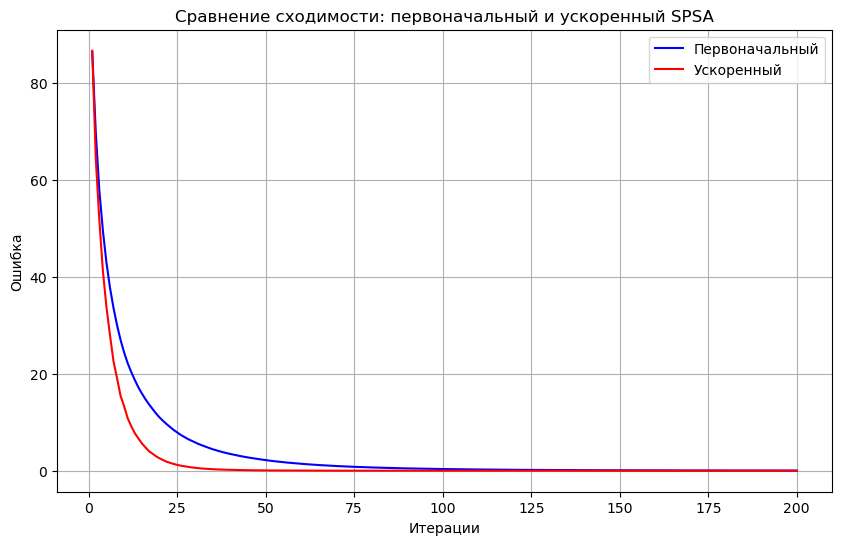

In [5]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
import time
import numpy as np
from random import random, sample
from typing import Dict, List, Set, Tuple

class Parameters:
    def __init__(self):
        self.d = 2  # number of dimensions (2D space)
        self.n = 0  # will be set when sensors are added
        self.m = 0  # will be set when targets are added
        self.N: Set[int] = set()  # indexes of sensors
        self.M: Set[int] = set()  # targets indexes
        self.s: Dict[int, np.ndarray] = {}  # sensors coordinates
        self.s_norms: Dict[int, float] = {}  # norms of sensors coordinates
        self.r: Dict[int, np.ndarray] = {}  # targets coordinates
        self.meas: Dict[int, Dict[int, float]] = {}  # measurements
        self.weight: np.ndarray = np.array([])  # weight matrix
        
        # Algorithm parameters
        self.beta_1 = 0.05
        self.beta_2 = 0.05
        self.alpha_base = 0.3
        self.gamma_base = 0.2
        self.momentum = 0.95
        self.b = 1.0
        
    @property
    def beta(self):
        return self.beta_1 + self.beta_2
    
    def add_sensor(self, sensor_id: int, coordinates: np.ndarray):
        if sensor_id in self.N:
            raise ValueError(f"Sensor with ID {sensor_id} already exists")
        self.N.add(sensor_id)
        self.s[sensor_id] = coordinates
        self.s_norms[sensor_id] = np.sum(coordinates * coordinates)
        self.n = len(self.N)
        
    def add_target(self, target_id: int, coordinates: np.ndarray):
        if target_id in self.M:
            raise ValueError(f"Target with ID {target_id} already exists")
        self.M.add(target_id)
        self.r[target_id] = coordinates
        self.m = len(self.M)
        
    def generate_random_sensors(self, n: int, area_size: float = 20.0):
        for i in range(1, n + 1):
            coords = np.array([random() * area_size, random() * area_size])
            self.add_sensor(i, coords)
    
    def generate_random_targets(self, m: int, area_size: float = 40.0):
        for i in range(1, m + 1):
            coords = np.array([random() * area_size, random() * area_size])
            self.add_target(i, coords)
    
    def calculate_measurements(self):
        self.meas = {}
        for target_id in self.M:
            self.meas[target_id] = {}
            for sensor_id in self.N:
                self.meas[target_id][sensor_id] = np.sum(
                    (self.r[target_id] - self.s[sensor_id]) ** 2)
    
    def generate_weight_matrix(self, connectivity: float = 0.5):
        if self.n == 0:
            raise ValueError("No sensors defined")

        raw_mat = np.random.rand(self.n, self.n)
        weight = np.tril(raw_mat) + np.tril(raw_mat, -1).T
        threshold = np.percentile(weight, (1 - connectivity) * 100)
        weight = (weight >= threshold).astype(float)
        np.fill_diagonal(weight, 0)

        for i in range(self.n):
            if np.all(weight[i] == 0):
                j = np.random.choice([x for x in range(self.n) if x != i])
                weight[i, j] = 1
                weight[j, i] = 1

        row_sums = weight.sum(axis=1)
        weight = weight / row_sums[:, np.newaxis]

        if np.any(np.isnan(weight)) or np.any(np.isinf(weight)):
            raise ValueError("Invalid weight matrix")

        self.weight = weight
        return weight

class SPSA_Base:
    def __init__(self, parameters: Parameters):
        self.params = parameters
        self.d = parameters.d
        self.Delta_abs_value = 1 / np.sqrt(self.d)
        self.errors = []
        
    def f_l_i(self, l: int, i: int, r_hat_l: np.ndarray, neighbors: dict) -> float:
        C = self.C_i(i, neighbors)
        D = self.D_l_i(l, i, neighbors)
        try:
            C_i_inv = np.linalg.inv(C)
        except np.linalg.LinAlgError:
            C_i_inv = np.linalg.pinv(C)
        diff = r_hat_l - np.matmul(C_i_inv, D)
        return np.sum(diff * diff)
    
    def C_i(self, i: int, neighbors: dict) -> np.ndarray:
        C_i = [self.params.s[j] - self.params.s[i] for j in neighbors.get(i, [])]
        return 2 * np.array(C_i) if C_i else np.zeros((0, self.d))
    
    def D_l_i(self, l: int, i: int, neighbors: dict) -> np.ndarray:
        Dli = [self.calc_D_l_i_j(self.params.meas[l], i, j) for j in neighbors.get(i, [])]
        return np.array(Dli) if Dli else np.zeros(0)
    
    def calc_D_l_i_j(self, meas_l: dict, i: int, j: int) -> float:
        return (meas_l[i] - meas_l[j]) + (self.params.s_norms[j] - self.params.s_norms[i])
    
    def compute_error(self, vector_1: np.ndarray, vector_2: np.ndarray) -> float:
        return np.sum((vector_1 - vector_2) ** 2)
    
    def get_random_neighbors(self, weight: np.ndarray, max_neighbors: int = 2) -> Dict[int, List[int]]:
        adjacency = (weight != 0).astype(int)
        np.fill_diagonal(adjacency, 0)
        neighbors = {}
        for sensor in self.params.N:
            all_neighbors = [j+1 for j, connected in enumerate(adjacency[sensor-1]) if connected]
            if all_neighbors:
                sorted_neighbors = sorted(all_neighbors, 
                                       key=lambda j: weight[sensor-1, j-1], 
                                       reverse=True)
                neighbors[sensor] = sorted_neighbors[:min(max_neighbors, len(sorted_neighbors))]
            else:
                neighbors[sensor] = []
        return neighbors

class SPSA_v3(SPSA_Base):
    """Original version (0.3.0)"""
    def run(self, num_steps: int = 100) -> Tuple[Dict[int, float], Dict[int, np.ndarray]]:
        weight = self.params.weight
        theta_hat = {
            t: {s: self.params.r[t] + np.random.normal(0, 2, self.d) for s in self.params.N}
            for t in self.params.M
        }
        
        alpha = 1.0
        self.errors = []
        
        for k in range(1, num_steps + 1):
            theta_new = {}
            err = 0
            
            alpha_new = (1 + np.sqrt(1 + 4 * alpha**2)) / 2
            gamma_momentum = (1 - alpha) / alpha_new
            
            adaptive_factor = 1.0 / np.sqrt(k)
            current_alpha = self.params.alpha_base * adaptive_factor
            current_gamma = self.params.gamma_base * adaptive_factor
            
            for l in self.params.M:
                theta_new[l] = {}
                neighbors = self.get_random_neighbors(weight)
                
                for i in self.params.N:
                    delta = np.array([1 if random() < 0.5 else -1 for _ in range(self.d)]) * self.Delta_abs_value
                    
                    x1 = theta_hat[l][i] + self.params.beta_1 * delta
                    x2 = theta_hat[l][i] - self.params.beta_2 * delta
                    
                    y1 = self.f_l_i(l, i, x1, neighbors)
                    y2 = self.f_l_i(l, i, x2, neighbors)
                    
                    spsa = (y1 - y2) / (2 * self.params.beta) * delta
                    
                    neighbors_i = neighbors.get(i, [])
                    b = weight[i - 1]
                    theta_diff = [abs(b[j - 1]) * (theta_hat[l][i] - theta_hat[l][j]) for j in neighbors_i]
                    
                    theta_new[l][i] = theta_hat[l][i] - (current_alpha * spsa + current_gamma * sum(theta_diff))
                
                err += sum(self.compute_error(theta_new[l][i], self.params.r[l]) for i in self.params.N) / len(self.params.N)
            
            alpha = alpha_new
            theta_hat = theta_new
            self.errors.append(err)
            
            if k % 10 == 0:
                print(f"Iteration {k}: Error = {err:.2f}")
        
        return self.errors, theta_hat

class SPSA_v4(SPSA_Base):
    """Improved version (0.4.0)"""
    def run(self, num_steps: int = 100) -> Tuple[Dict[int, float], Dict[int, np.ndarray]]:
        weight = self.params.weight
        theta_hat = {
            t: {s: self.params.r[t] + np.random.normal(0, 2, self.d) for s in self.params.N}
            for t in self.params.M
        }
        y_hat = {
            t: {s: theta_hat[t][s].copy() for s in self.params.N}
            for t in self.params.M
        }
        
        alpha = 1.0
        self.errors = []
        
        for k in range(1, num_steps + 1):
            theta_new = {}
            err = 0
            
            alpha_new = (1 + np.sqrt(1 + 4 * alpha**2)) / 2
            gamma_momentum = (1 - alpha) / alpha_new
            
            adaptive_factor = 1.0 / (1 + 0.01*k)  # Faster decay
            current_alpha = self.params.alpha_base * adaptive_factor
            current_gamma = self.params.gamma_base * adaptive_factor
            
            for l in self.params.M:
                theta_new[l] = {}
                neighbors = self.get_random_neighbors(weight)
                
                for i in self.params.N:
                    delta = np.array([1 if random() < 0.5 else -1 for _ in range(self.d)]) * self.Delta_abs_value
                    
                    x1 = y_hat[l][i] + self.params.beta_1 * delta
                    x2 = y_hat[l][i] - self.params.beta_2 * delta
                    
                    y1 = self.f_l_i(l, i, x1, neighbors)
                    y2 = self.f_l_i(l, i, x2, neighbors)
                    
                    spsa = (y1 - y2) / (2 * self.params.beta) * delta * (1 + 0.1 * np.sin(k/10))  # Added oscillation
                    
                    neighbors_i = neighbors.get(i, [])
                    b = weight[i - 1]
                    theta_diff = [abs(b[j - 1]) * (y_hat[l][i] - y_hat[l][j]) for j in neighbors_i]
                    
                    v_new = current_alpha * spsa + current_gamma * sum(theta_diff)
                    theta_new[l][i] = y_hat[l][i] - v_new
                    y_hat[l][i] = theta_new[l][i] + gamma_momentum * (theta_new[l][i] - theta_hat[l][i])
                
                err += sum(self.compute_error(theta_new[l][i], self.params.r[l]) for i in self.params.N) / len(self.params.N)
            
            alpha = alpha_new
            theta_hat = theta_new
            self.errors.append(err)
            
            if k % 10 == 0:
                print(f"Iteration {k}: Error = {err:.2f}")
        
        return self.errors, theta_hat

def compare_methods():
    # Initialize parameters
    params = Parameters()
    num_sensors = 100
    num_targets = 15
    
    params.generate_random_sensors(num_sensors)
    params.generate_random_targets(num_targets)
    params.calculate_measurements()
    params.generate_weight_matrix(connectivity=0.6)
    
    # Run both versions
    print("Running original version (0.3.0)...")
    spsa_v3 = SPSA_v3(params)
    errors_v3, _ = spsa_v3.run(num_steps=200)
    
    print("\nRunning improved version (0.4.0)...")
    spsa_v4 = SPSA_v4(params)
    errors_v4, _ = spsa_v4.run(num_steps=200)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(errors_v3)+1), errors_v3, 'b-', label='Первоначальный')
    plt.plot(range(1, len(errors_v4)+1), errors_v4, 'r-', label='Ускоренный')
    
    plt.xlabel('Итерации')
    plt.ylabel('Ошибка')
    plt.title('Сравнение сходимости: первоначальный и ускоренный SPSA')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    compare_methods()

Сохранение анимации...
Анимация сохранена как spsa_color_clouds.gif


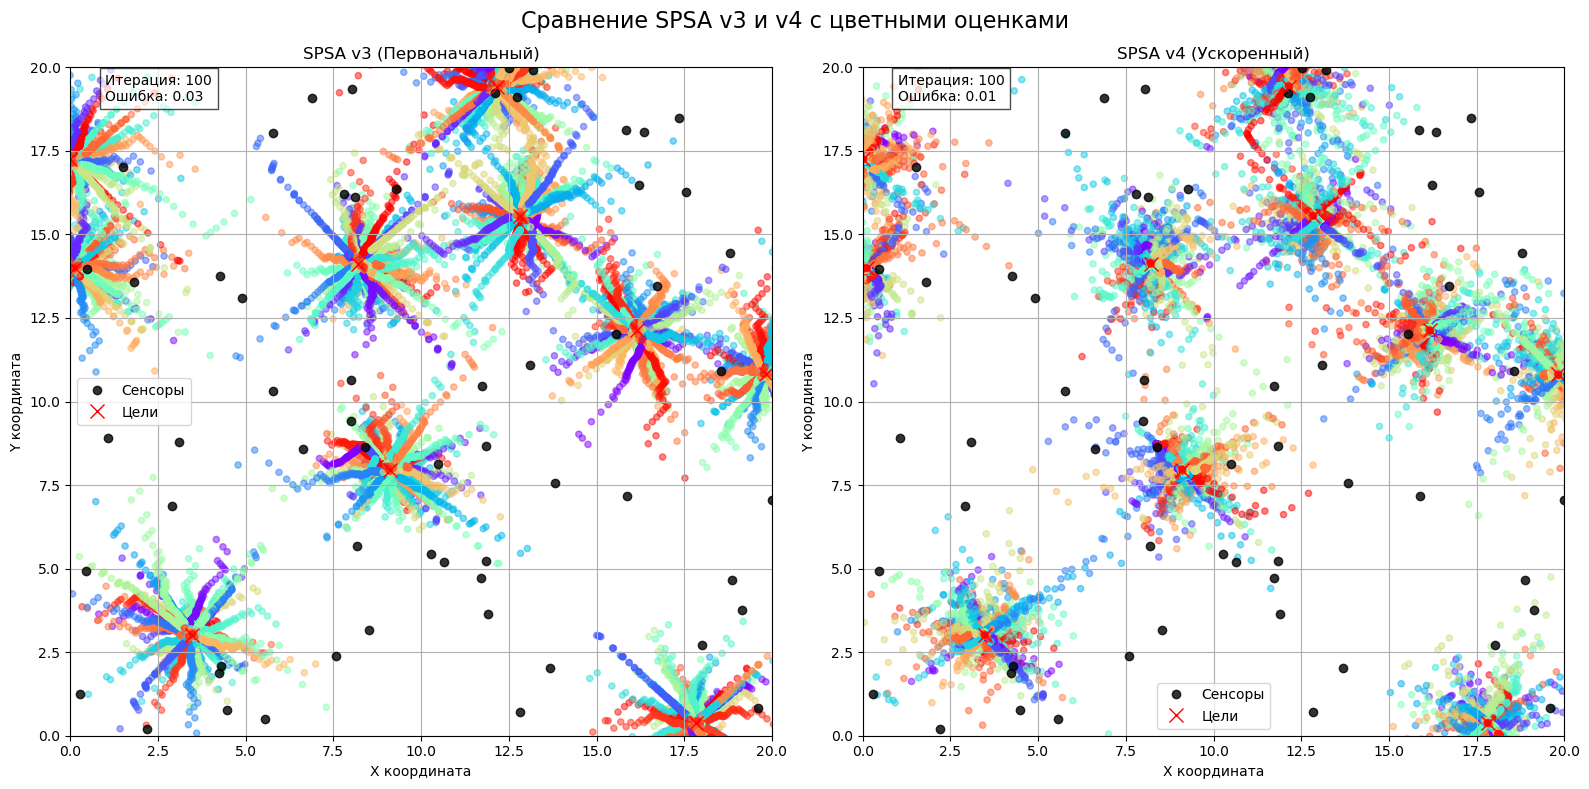